# ML-Lecture4.2

#### Loading Data from Before

In [1]:
%load_ext autoreload
%autoreload 2

#### Libraries

In [3]:
%matplotlib inline

import sys

# or wherever you have saved the repo
sys.path.append('/Users/tlee010/Desktop/github_repos/fastai/')


from fastai.imports import *
from fastai.structured import *
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics

#### Load the feather file from before

In [4]:
import feather
df_raw = feather.read_dataframe('/Users/tlee010/kaggle/bulldozers/bulldozers-raw')
print('import complete')

import complete


#### Prep the data with splits and functions for the bulldozers 

In [6]:
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice')

In [7]:
def split_vals(a,n): return a[:n], a[n:]
n_valid = 12000
n_trn = len(df_trn)-n_valid
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)
raw_train, raw_valid = split_vals(df_raw, n_trn)

In [8]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

# Today's Goals

### Validation Sets

### Test Sets

### Finalizing Random Forest Intepretation

### Building your own Random Forest from scratch

#### Exams : All coding - random forests

## What should I be able to do at this point? Week4

- Replicate everything you've seen on a different dataset. We've seen the `bulldozer` dataset. It contains rows and columns. Unstructured would be images / audio etc. 

- Lesson 1 : Here is how we can create a random forest. Training validation. Score and OOB score. Here's how we reduce overfitting. Here's how we do it with min samples leaf / and number of trees. And get a reasonably good score

    - What's important?
    - Feature important?
    - How confident are you of the different predictions
    - Which features should we remove
    - What is the relationship between some independent variable, and other dependable variabl, all other things being equal.
    
**Note** - there's always something to deal with (too large), super high cardinality variables, time dependence. There's always some twist in the dataset to deal with. What's driving the outcome, and how is it being driven.

## Complex Technical Concepts

##### Talking about the 'ICE Year Made Plot'

This tells you that there is basically an linear relationship. Changes the year for all values and makes a prediction. What if all things being the same, this was built a different year. The model is NOT being retrained. We are using the model and then re-running the prediction.

This plot is only looking for a subsample of 500 different years (after year 1930), for computational reasons.

y = log( change in sales price vs. if the product was made after 1960)

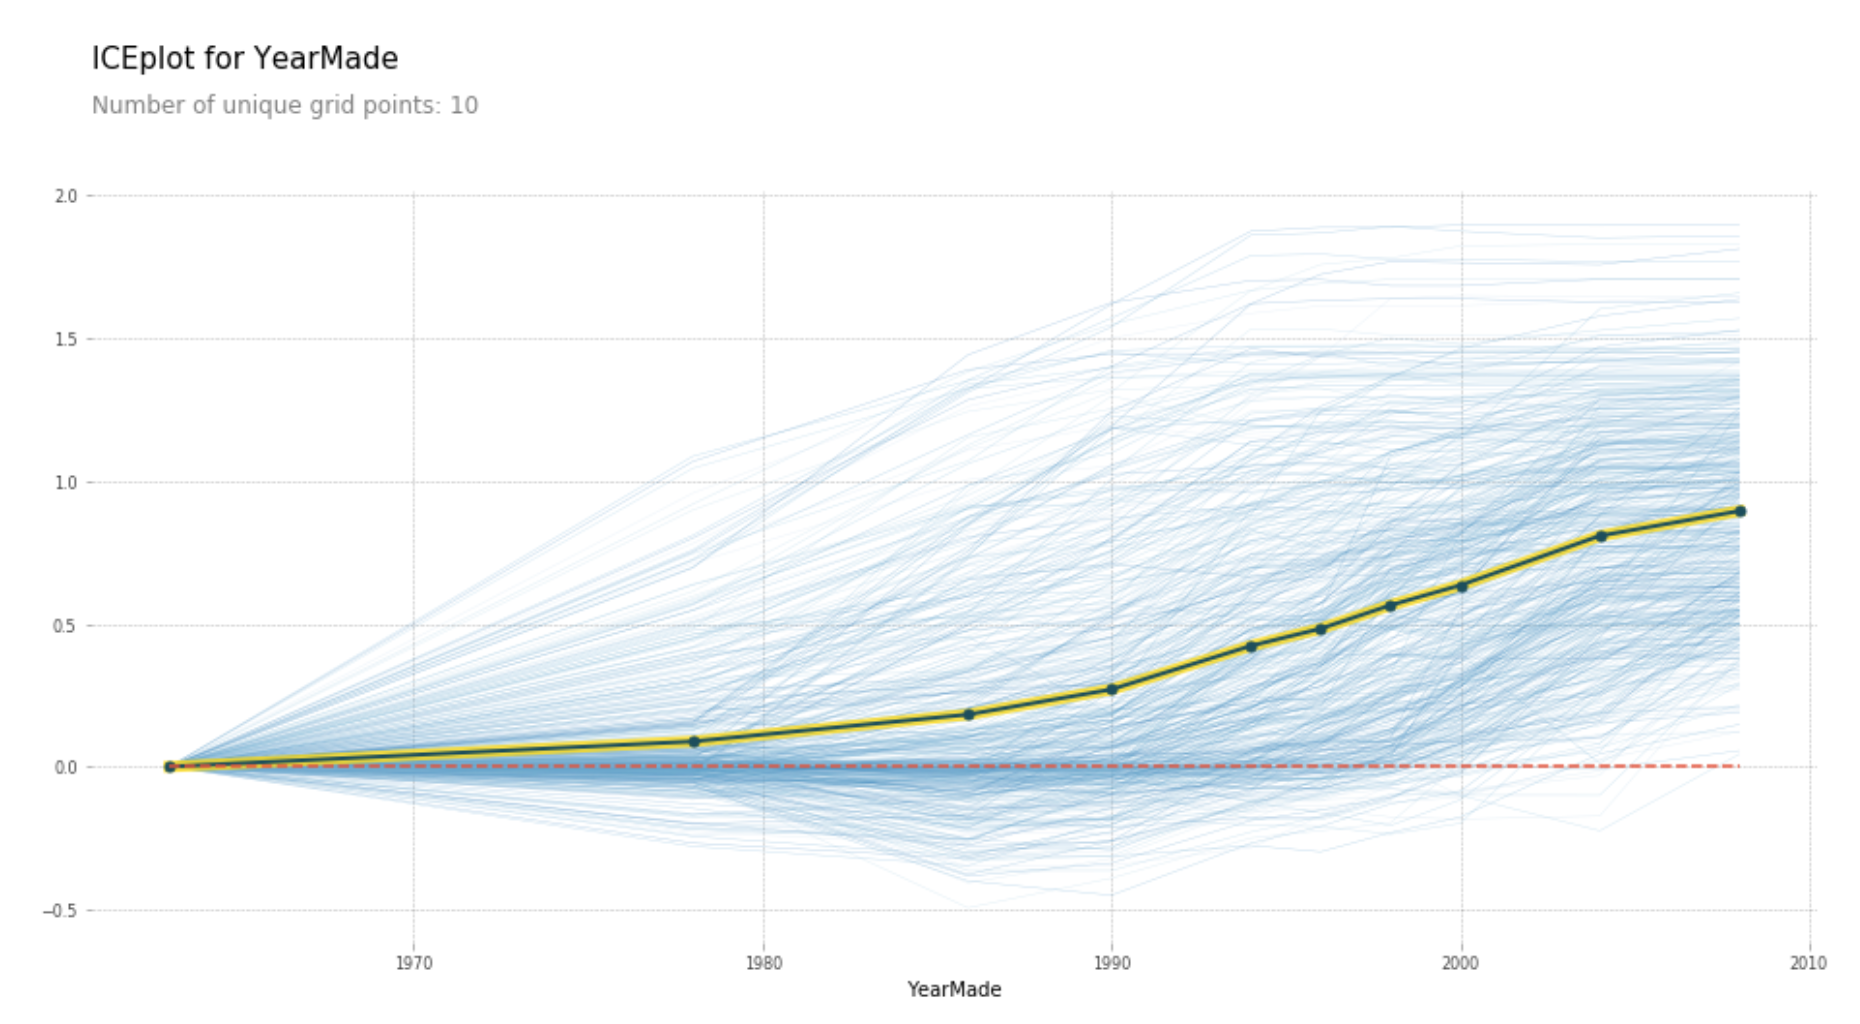

##### Outlier Handling?

**Outlier in Dependent** If there's a outlier in the dependent variable, the average will be heavily affected. Leaf nodes will then have incorrect averages ( won't change the splits too much). Tree won't look that different, but the predictions will be different.

**Outlier in Independent** Not going to change anything, forests are pretty resilient.


In [14]:
from pdpbox import pdp
from plotnine import *
set_rf_samples(50000)

In [15]:
df_trn2, y_trn, nas = proc_df(df_raw, 'SalePrice', max_n_cat=7)
X_train, X_valid = split_vals(df_trn2, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1)
m.fit(X_train, y_train);

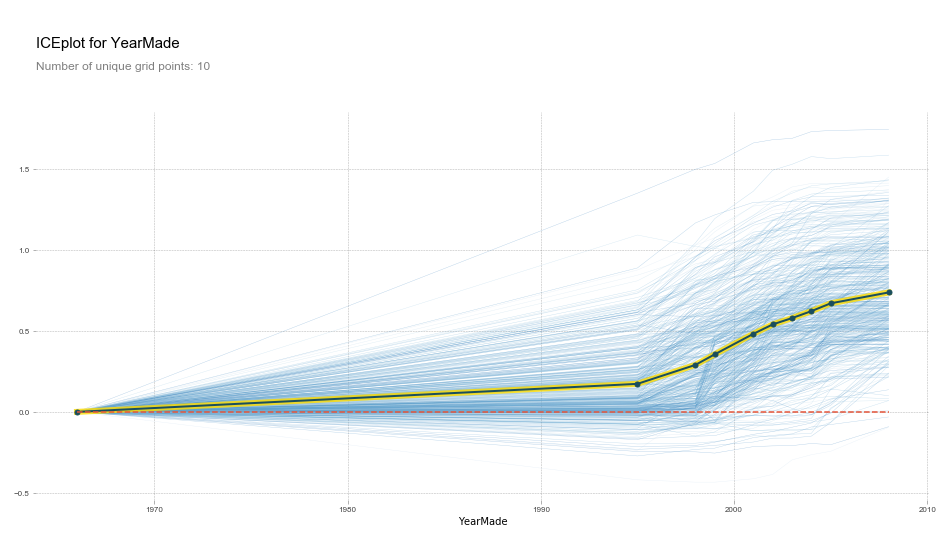

In [16]:
x_all = get_sample(df_raw[df_raw.YearMade>1930], 500)
x = get_sample(X_train[X_train.YearMade>1930], 500)

def plot_pdp(feat, clusters=None, feat_name=None):
    feat_name = feat_name or feat
    p = pdp.pdp_isolate(m, x, feat)
    return pdp.pdp_plot(p, feat_name, plot_lines=True, 
                        cluster=clusters is not None, n_cluster_centers=clusters)

plot_pdp('YearMade')

## Tree Interpretation

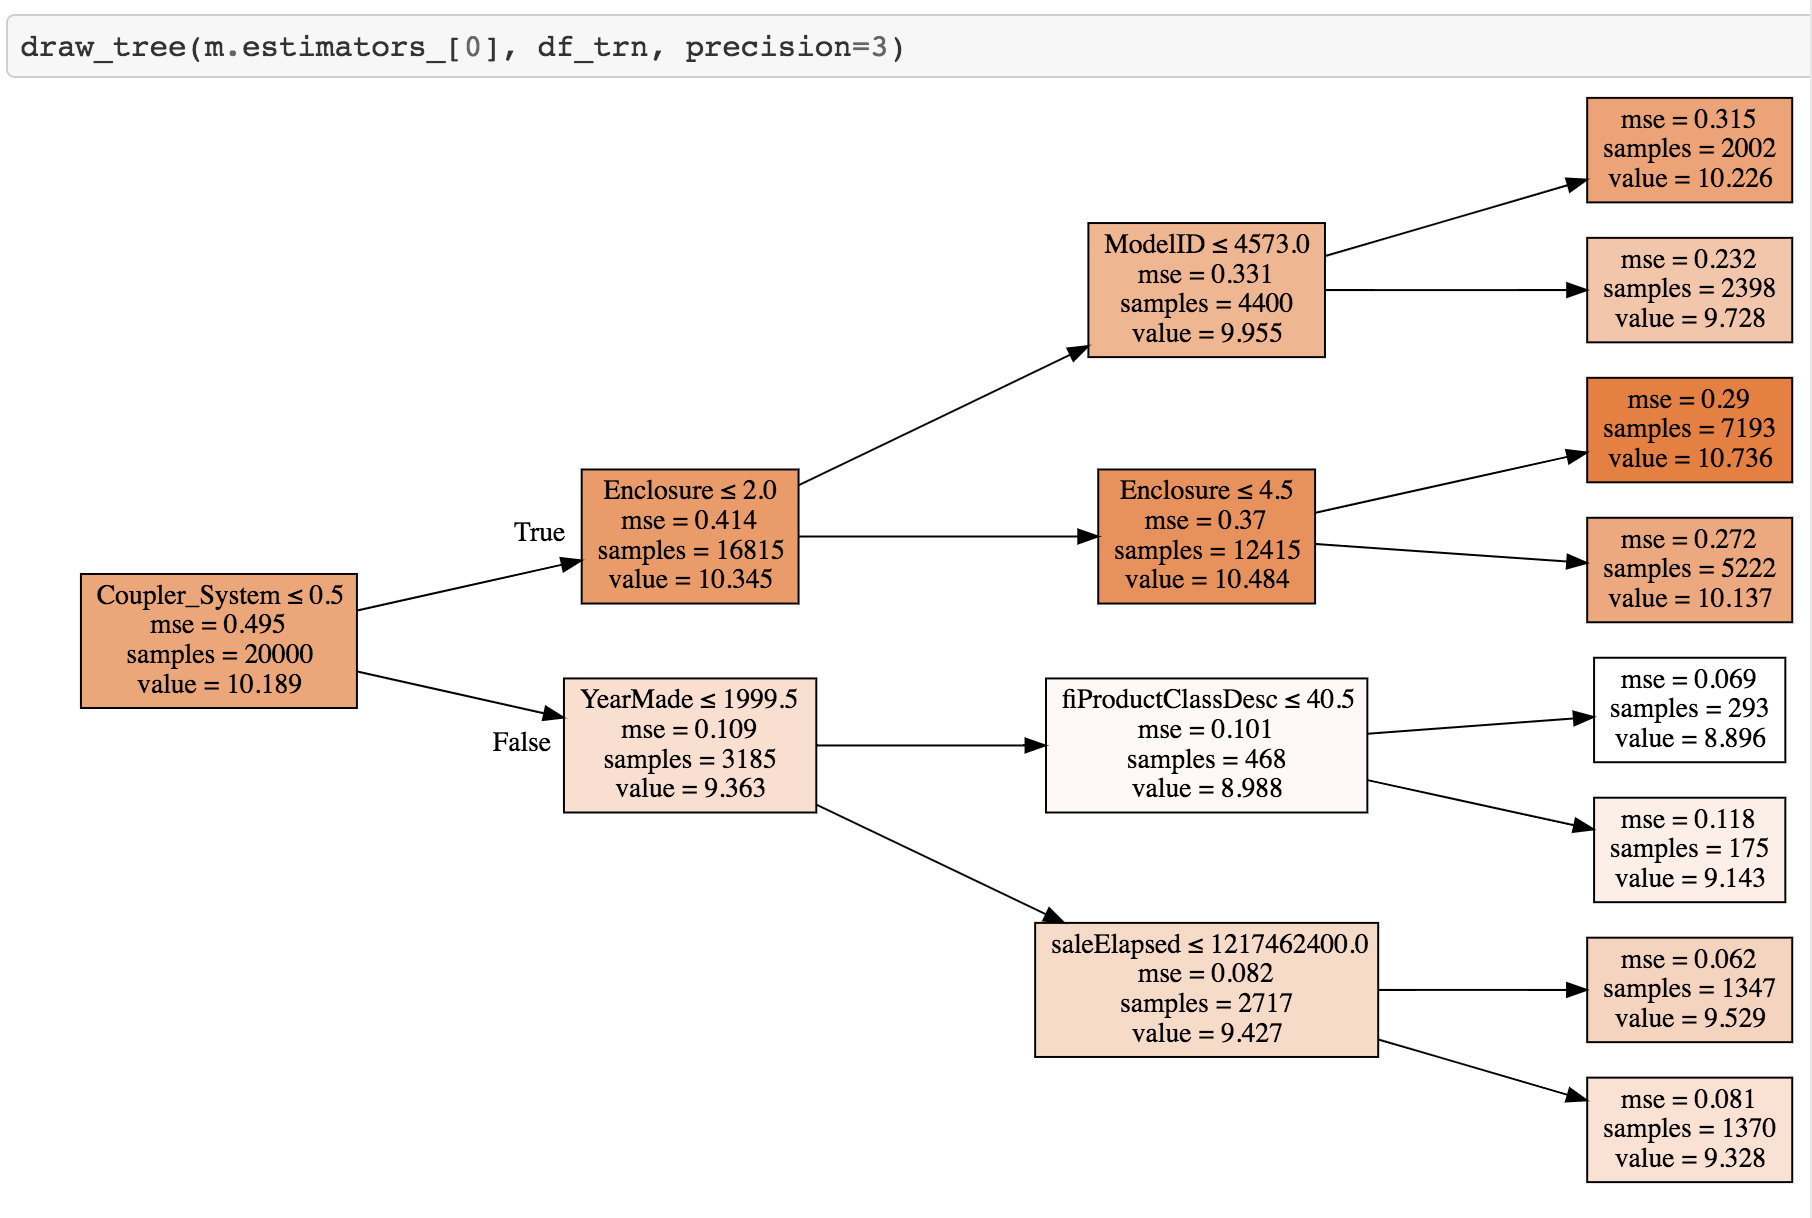

## Tree Interpreter

https://github.com/andosa/treeinterpreter

#### Looking at the affects of the different pieces

- All - 10.189
- Coupler <=0.5 - 0.156
- Enclosure <=2 -0.395 - 0.395
- ModelID <= 4573 - 0.276
- Total - 10.226

#### Waterfall chart - make one with the changes

Bias - is the mean of the first value

![](https://cdn.ablebits.com/_img-blog/waterfall-charts/waterfall-chart.png)

### Data prep - consolidated from Lesson2-rf

https://github.com/fastai/fastai/blob/master/courses/ml1/lesson2-rf_interpretation.ipynb


In [35]:
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice')

def split_vals(a,n): return a[:n], a[n:]
n_valid = 12000
n_trn = len(df_trn)-n_valid
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)
raw_train, raw_valid = split_vals(df_raw, n_trn)


def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)
    
    
set_rf_samples(50000)

m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)
fi = rf_feat_importance(m, df_trn); fi[:10]


[0.20546521753082297, 0.2509610106685115, 0.91177098095443698, 0.88752383935747015, 0.89480604501280936]


,cols,imp
64,age,0.144301
13,ProductSize,0.109078
14,fiProductClassDesc,0.096000
37,Coupler_System,0.079007
5,YearMade,0.068811
39,Hydraulics_Flow,0.064676
2,ModelID,0.064318
38,Grouser_Tracks,0.049578
10,fiSecondaryDesc,0.039151
19,Enclosure,0.032419


### Tracking a Row's Prediction through tree interpreter / Contribution Editing

#### Bias - or the mean value

```python
prediction, bias, contributions = ti.predict(m, row)
prediction[0], bias[0]
(9.308455935297518, 10.106152392409408)
```


#### Now we add all the tree influences
```python
[('ProductSize', 'Mini', -0.54680742853695008),

 ('age', 11, -0.12507089451852943),

('fiProductClassDesc',
  'Hydraulic Excavator, Track - 3.0 to 4.0 Metric Tons',
  -0.11143111128570773),
```

#### Then we add in all the contributions
```
contributions[0].sum()
-0.7383536391949419

```

#### Final prediction
```python
prediction[0],
9.308455935297518
```

**Why its important** - the tree interpretter. We can graphically and easily describe how we track the prediction. 


**When combining different trees, what if you are missing features in some?** - Even if feature only appears once, the average will be that single value, divided by the number of the trees.

**What if this is classification ? ** the trees will be split by the average of the 1's and 0s. So it would answer "how often does this occur"? We usually use cross-entropy, which is negative log likelihood. RMSE is not a bad approach.

In [37]:
from treeinterpreter import treeinterpreter as ti

feats=['SalesID', 'saleElapsed', 'MachineID', 'age', 'YearMade', 'saleDayofyear']
to_keep = fi[fi.imp>0.005].cols; len(to_keep)
df_keep = df_trn[to_keep].copy()

X_train, X_valid = split_vals(df_keep, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)


df_raw.YearMade[df_raw.YearMade<1950] = 1950
df_keep['age'] = df_raw['age'] = df_raw.saleYear-df_raw.YearMade

X_train, X_valid = split_vals(df_keep, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1)
m.fit(X_train, y_train)

df_train, df_valid = split_vals(df_raw[df_keep.columns], n_trn)

In [38]:
row = X_valid.values[None,0]; row

array([[        11,          5,         17,          0,       1999,          0,        665,          0,
                 0,          1,       3232,       1111, 1284595200,    4364751,          0,    2300944,
                 4,       2010,          0,          4,          0,        259,         35,         16,
                 2,         12]])

In [39]:
prediction, bias, contributions = ti.predict(m, row)

In [40]:
prediction[0], bias[0]

(9.4120004499352454, 10.106191974635667)

In [41]:
idxs = np.argsort(contributions[0])

In [42]:
[o for o in zip(df_keep.columns[idxs], df_valid.iloc[0][idxs], contributions[0][idxs])]

[('ProductSize', 'Mini', -0.47483352839715726),
 ('age', 11, -0.097889119451887302),
 ('fiProductClassDesc',
  'Hydraulic Excavator, Track - 3.0 to 4.0 Metric Tons',
  -0.076471050183981107),
 ('fiBaseModel', 'KX121', -0.066841565760360627),
 ('fiSecondaryDesc', nan, -0.053024465856433965),
 ('fiModelDesc', 'KX1212', -0.050252781130077161),
 ('fiModelDescriptor', nan, -0.030473957539144125),
 ('Enclosure', 'EROPS', -0.030300855486490041),
 ('MachineID', 2300944, -0.0214149038864321),
 ('SalesID', 4364751, -0.018611091431251836),
 ('state', 'Ohio', -0.018457661613301778),
 ('saleElapsed', 1284595200, -0.006866623476152434),
 ('saleYear', 2010, -0.0054711996267921672),
 ('saleDayofyear', 259, -0.0031785685023805409),
 ('Tire_Size', nan, -0.0030972153456157335),
 ('Drive_System', nan, 0.0035246475564432167),
 ('ProductGroupDesc', 'Track Excavators', 0.0071280184890852635),
 ('ProductGroup', 'TEX', 0.0078641941839247224),
 ('saleDay', 16, 0.011294146761423107),
 ('Hydraulics', 'Standard', 

In [43]:
contributions[0].sum()

-0.69419152470041912

## Validation Sets

Building a model on a training set. We make a accurate training set, but the test set says that its not good. We tune + go back to the test set, and see if it looks better. We iterate, and we find something that works really well.

Q: Does that mean we have reached **generalization** ? 

#### MAYBE

So now we have 3 data sets :

- TRAIN
- VALID
- TEST (lock away) <- final word on if generalized

#### Creating an appropriate test set is the most important thing

1. If the test set is wrong, and does not tell you if the model is valid or not. You dont know if you are right or not.

2. It takes time to put model into production, to test and implement. And maybe by the time that it goes to market the world is a very different place. 

3. The test set should also take real world into account. Lets see what it looks like for forecasting:

|Set | Duration | 
|---|---------|
|Test| most recent 3 months |
|Valid |  the next recent 3 months |
|train | other months |


#### What Kaggle does for test sets

<center>
##### 30% is used for the Public Leaderboard
##### 70% is the private leaderboard (only revealed at the end)
</center>
If you drop in Kaggle between the boards, that means you are probably overfitting. Ideally you should have similar scores between the two datasets.

** Example ** - start-up built a new recommender based on user social graphs (with history), but during the roll out, all the users were brand new to the service without a social history so the training and the actual use was much different between the two

** Example Grocery ** - Validation sets

- Last Two Weeks
- Last Month
- Last 2 months etc.

Then plot these validation sets against the kaggle to determine how consistent the scores are

#### Q: We have 2 scores from the OOB and score from a random training set how would they compare?

**Answer** For the OOB - we take a row, was it used in tree 1, 2, 3, or 4? So we can only use a subsets of the trees. We are using a smaller subset of the overall forest. More trees = more average = smoother results. So OOB is a bit worse, since fewer number of trees.

**If the R^2 is better for OOB** - you aren't overfitting, but validation score is bad, you are still generalized, but still not doing well of predicting. Could be missing a feature, or could be missing some additional features.


## How is my validation set different to my training set?

#### Test set, is it a random set or different in some way? [IN this example, looking at the time dependence]

1. combine the datasets together (test and train)
2. 0 is training, 1 is test set
3. Try to predict if the dataset is from the training or the test set (don't need target')
4. Use a random forest

In [45]:
df_ext = df_keep.copy()
df_ext['is_valid'] = 1
df_ext.is_valid[:n_trn] = 0
x, y, _ = proc_df(df_ext, 'is_valid')

In [46]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y);
m.oob_score_

0.99999002804612025

In [47]:
fi = rf_feat_importance(m, x); fi[:10]

,cols,imp
13,SalesID,0.812214
12,saleElapsed,0.140304
15,MachineID,0.027869
17,saleYear,0.007917
4,YearMade,0.003177
11,fiBaseModel,0.001311
9,Enclosure,0.001307
10,fiModelDesc,0.001139
25,Hydraulics,0.001096
21,saleDayofyear,0.000907


#### Discussion:  more recent machines are given newer ids.  Lets look at the first 3

In [48]:
feats=['SalesID', 'saleElapsed', 'MachineID']

In [49]:
(X_train[feats]/1000).describe()

,SalesID,saleElapsed,MachineID
count,389125.000000,3.891250e+05,389125.000000
mean,1800.452485,1.084797e+06,1206.796148
std,595.627288,1.803913e+05,430.850552
min,1139.246000,6.009984e+05,0.000000
25%,1413.348000,9.666432e+05,1087.016000
50%,1632.093000,1.134605e+06,1273.859000
75%,2210.453000,1.234138e+06,1458.661000
max,4364.741000,1.325117e+06,2313.821000


### Confirm that these fields are time dependent

In [50]:
(X_valid[feats]/1000).describe()

,SalesID,saleElapsed,MachineID
count,12000.000000,1.200000e+04,12000.000000
mean,5786.967651,1.306609e+06,1578.049709
std,836.899608,2.497808e+04,589.497173
min,4364.751000,1.174522e+06,0.830000
25%,4408.580750,1.309219e+06,1271.225250
50%,6272.538500,1.316045e+06,1825.317000
75%,6291.792250,1.321402e+06,1907.858000
max,6333.342000,1.325203e+06,2486.330000


In [51]:
x.drop(feats, axis=1, inplace=True)

### Retrain and examine (without SalesID, saleElapse, MachineID)

In [52]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y);
m.oob_score_

0.98550825802430664

In [53]:
fi = rf_feat_importance(m, x); fi[:10]

,cols,imp
14,saleYear,0.323026
18,saleDayofyear,0.254053
6,ModelID,0.055675
20,saleDay,0.049019
10,fiModelDesc,0.039258
19,state,0.036700
4,YearMade,0.033622
11,fiBaseModel,0.029656
0,age,0.028444
9,Enclosure,0.025474


### Lets' make a RF, remove these features 1 at a time

In [54]:
set_rf_samples(50000)

#### Suspected time dependent features to randomly drop

In [59]:
feats=['SalesID', 'saleElapsed', 'MachineID', 'age', 'YearMade', 'saleDayofyear']

In [60]:
X_train, X_valid = split_vals(df_keep, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.1239400515957124, 0.22291901531335712, 0.96789607210517048, 0.9112553448779237, 0.90931684420931058]


#### Loop through and try and predict

In [61]:
for f in feats:
    df_subs = df_keep.drop(f, axis=1)
    X_train, X_valid = split_vals(df_subs, n_trn)
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(X_train, y_train)
    print(f)
    print_score(m)

SalesID
[0.1277492887571901, 0.2204551799395666, 0.96589234920766698, 0.91320622270794161, 0.90939053874335463]
saleElapsed
[0.12710539554859768, 0.22632082290926267, 0.96623530748651576, 0.90852614098104056, 0.90801683810739509]
MachineID
[0.12716844809238703, 0.2202002816170202, 0.96620180021024593, 0.91340681493893672, 0.91102000725277199]
age
[0.12476982192438187, 0.2249066056487989, 0.96746476585288899, 0.9096657597638339, 0.90975752919803488]
YearMade
[0.12462348237415515, 0.2248658079813547, 0.9675410406974656, 0.90969852973976595, 0.90968496748530769]
saleDayofyear
[0.1277516360233823, 0.22391746049979452, 0.96589109580779475, 0.91045859717612299, 0.90856106645875168]


#### Discussion 

We remove SalesID and MachineID and saleDay of the year because it seems like it is time dependent which we want to remove


In [62]:
reset_rf_samples()

#### Our Current Best Model

In [58]:
df_subs = df_keep.drop(['SalesID', 'MachineID', 'saleDayofyear'], axis=1)
X_train, X_valid = split_vals(df_subs, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.13685772048830452, 0.21666937899122155, 0.96085525842884623, 0.91616158655825652, 0.91016508458294254]


In [ ]:
plot_fi(rf_feat_importance(m, X_train));

#### Our Best Model

Upping the number of trees.

In [63]:
m = RandomForestRegressor(n_estimators=160, max_features=0.5, n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 7min 9s, sys: 5.96 s, total: 7min 15s
Wall time: 1min 8s
[0.07483820926906463, 0.2204628379662015, 0.98829472556490661, 0.91320019263323127, 0.91431911498508012]


# RandomForest from Scratch

![https://github.com/fastai/fastai/blob/master/courses/ml1/lesson3-rf_foundations.ipynb](https://github.com/fastai/fastai/blob/master/courses/ml1/lesson3-rf_foundations.ipynb)

In [64]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### How do you know if you coded some thing incorrectly?

It's good to have a dataset to compare to. Test envir (existing library, lets replicate what it does) - we will get the same answers as sklearn. (Our golden standard)

In [66]:
%matplotlib inline

from fastai.imports import *
from fastai.structured import *
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics

### Load the Raw data

In [69]:
PATH = "data/bulldozers/"
%time df_raw = feather.read_dataframe('/Users/tlee010/kaggle/bulldozers/bulldozers-raw')


CPU times: user 109 ms, sys: 73.9 ms, total: 183 ms
Wall time: 290 ms


In [70]:
df_trn, y_trn, _ = proc_df(df_raw, 'SalePrice')

### Setup normal data splits

In [71]:
def split_vals(a,n): return a[:n], a[n:]
n_valid = 12000
n_trn = len(df_trn)-n_valid
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)
raw_train, raw_valid = split_vals(df_raw, n_trn)

### Writing Trees, assuming that some other things exist



In [89]:
class TreeEnsemble():
    
    ## this is called when TreeEnsemble() is used
    def __init__(self, x, y, n_trees, sample_sz, min_leaf=5):
        np.random.seed(42)
        
        # saving all the data to the object
        # self is the actual object, all the non-self ones, are the 
        # user inputs
        self.x, self.y, self.sample_sz, self.min_leaf = x, y, sample_sz, min_leaf

        # creating n amount of trees
        self.trees = [self.create_tree() for i in range(n_trees)]

    def create_tree(self):
        
        # getting random index, and limits how big it is by the sample size
        rnd_idxs = np.random.permutation(len(self.y))[:self.sample_sz]
        
        # Makes a new decision tree based on the random indexs
        return DecisionTree(self.x.iloc[idxs], self.y[rnd_idxs], 
                    idxs=np.array(range(self.sample_sz)), min_leaf=self.min_leaf)
         
    def predict(x):
        
        # for each tree, predict for each tree, then return the average
        # using list comprehension
        return np.mean([t.predict(x) for t in self.trees], axis=0)

In [90]:
# this basically just stores a bunch of data at the moment
class DecisionTree():
    def __init__(self, x,y,idxs, min_leaf=5):
        self.x, self.y, self.idxs, self.min_leaf = x, y, idxs, min_leaf

### Aside on Object Oriented Programming

A good beginners reference:

https://python.swaroopch.com/oop.html

##### Instantiate a tree ensemble

In [91]:
### note when this is called, __init__ ( ... ) is already called
a = TreeEnsemble(X_train, y_train, n_trees=10, sample_sz=1000, min_leaf=3)

In [92]:
a.min_leaf

3

##### Also note: we haven't designed predict yet. But since we haven't called it, there's no error

## Lets make a basic Model

In [93]:
m = TreeEnsemble(X_train, y_train, n_trees=10, sample_sz=1000, min_leaf=3)

#### Lets look at our random index sample that we discussed in the `create_tree` method

Note that the first tree will have all the ids.

In [94]:
m.create_tree().idxs[:25]

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24])

## Next week - go from all the row indexes - whats the best thing we can do 